In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import urllib.request
import datetime
import json
import glob
import sys
import os

from prophet import Prophet

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.grid'] = False

pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 100)

pd.options.display.float_format = '{:.2f}'.format

# 네이버 데이터랩 오픈 API 컨트롤러
- 출처 : [정우일 블로그](https://wooiljeong.github.io/python/naver_datalab_open_api/)
- plot_monthly_trend 오류 수정, 그래프 커스터마이징

In [51]:

class NaverDataLabOpenAPI():
    """
    네이버 데이터랩 오픈 API 컨트롤러 클래스
    """

    def __init__(self, client_id, client_secret):
        """
        인증키 설정 및 검색어 그룹 초기화
        """
        self.client_id = client_id
        self.client_secret = client_secret
        self.keywordGroups = []
        self.url = "https://openapi.naver.com/v1/datalab/search"

    def add_keyword_groups(self, group_dict):
        """
        검색어 그룹 추가
        """

        keyword_gorup = {
            'groupName': group_dict['groupName'],
            'keywords': group_dict['keywords']
        }
        
        self.keywordGroups.append(keyword_gorup)
        print(f">>> Num of keywordGroups: {len(self.keywordGroups)}")
        
    def get_data(self, startDate, endDate, timeUnit, device, ages, gender):
        """
        요청 결과 반환
        timeUnit - 'date', 'week', 'month'
        device - None, 'pc', 'mo'
        ages = [], ['1' ~ '11']
        gender = None, 'm', 'f'
        """

        # Request body
        body = json.dumps({
            "startDate": startDate,
            "endDate": endDate,
            "timeUnit": timeUnit,
            "keywordGroups": self.keywordGroups,
            "device": device,
            "ages": ages,
            "gender": gender
        }, ensure_ascii=False)
        
        # Results
        request = urllib.request.Request(self.url)
        request.add_header("X-Naver-Client-Id",self.client_id)
        request.add_header("X-Naver-Client-Secret",self.client_secret)
        request.add_header("Content-Type","application/json")
        response = urllib.request.urlopen(request, data=body.encode("utf-8"))
        rescode = response.getcode()
        if(rescode==200):
            # Json Result
            result = json.loads(response.read())
            
            df = pd.DataFrame(result['results'][0]['data'])[['period']]
            for i in range(len(self.keywordGroups)):
                tmp = pd.DataFrame(result['results'][i]['data'])
                tmp = tmp.rename(columns={'ratio': result['results'][i]['title']})
                df = pd.merge(df, tmp, how='left', on=['period'])
            self.df = df.rename(columns={'period': '날짜'})
            self.df['날짜'] = pd.to_datetime(self.df['날짜'])
            
        else:
            print("Error Code:" + rescode)
            
        return self.df
    
    def plot_daily_trend(self, title='일 별 검색어 트렌드'):
        """
        일 별 검색어 트렌드 그래프 출력
        """
        colList = self.df.columns[1:]
        n_col = len(colList)

        fig, ax = plt.subplots(figsize=(12,6))
        plt.title(title, size=20, weight='bold')
        for i in range(n_col):
            sns.lineplot(x=self.df['날짜'], y=self.df[colList[i]], label=colList[i], ax=ax)

        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # 그리드 설정
        plt.grid(False)
        ax.grid(axis='y', which='major', color='lightgray')
        ax.grid(axis='y', which='minor', ls=':')
        
        plt.legend(loc='upper right')
        plt.ylabel('검색량')
        
        return fig
    
    def plot_monthly_trend(self, title='월 별 검색어 트렌드'):
        """
        월 별 검색어 트렌드 그래프 출력
        """
        df = self.df.copy()
        df['년도'] = df['날짜'].dt.year
        df['월'] = df['날짜'].dt.month

        monthly_avg = df.groupby(['년도', '월']).mean().reset_index()

        # '년도'와 '월' 열을 사용하여 새로운 '날짜' 열을 생성
        monthly_avg['날짜'] = pd.to_datetime(monthly_avg.rename(columns={'년도':'year', '월':'month'})[['year', 'month']].assign(day=1))

        # 필요없는 '년도'와 '월' 열을 제거
        monthly_avg = monthly_avg.drop(['년도', '월'], axis=1)

        colList = monthly_avg.columns.drop(['날짜'])
        n_col = len(colList)
                
        fig, ax = plt.subplots(figsize=(12,6))
        plt.title(title, size=20, weight='bold')
        for i in range(n_col):
            sns.lineplot(x=monthly_avg['날짜'], y=monthly_avg[colList[i]], label=colList[i], ax=ax)
        
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # 그리드 설정
        plt.grid(False)
        ax.grid(axis='y', which='major', color='lightgray')
        ax.grid(axis='y', which='minor', ls=':')

        plt.legend(loc='upper right')
        plt.ylabel('검색량')
        
        return fig
    
    def plot_pred_trend(self, days):
        """
        검색어 시계열 트렌드 예측 그래프 출력
        days: 예측일수
        """
        colList = self.df.columns[1:]
        n_col = len(colList)
        
        fig_list = []
        for i in range(n_col):
            
            globals()[f"df_{str(i)}"] = self.df[['날짜', f'{colList[i]}']]
            globals()[f"df_{str(i)}"] = globals()[f"df_{str(i)}"].rename(columns={'날짜': 'ds', f'{colList[i]}': 'y'})

            m = Prophet()
            m.fit(globals()[f"df_{str(i)}"])

            future = m.make_future_dataframe(periods=days)
            forecast = m.predict(future)
            forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
            
            globals()[f"fig_{str(i)}"] = m.plot(forecast, figsize=(12,6))
            plt.title(colList[i], size=20, weight='bold')
            
            fig_list.append(globals()[f"fig_{str(i)}"])
            
        return fig_list

In [52]:
my_id = 'xJGtrgPmJcERnrL3FlFB'
my_secret = '_0fAHxrs6b'

naver = NaverDataLabOpenAPI(my_id, my_secret)

- 검색어 설정이 적절한지 확인 필요

In [53]:
bank_keyword_set = {
    'kb': {'groupName': "국민은행", 'keywords': ["국민은행","kb국민은행","kb은행"]},
    'woori': {'groupName': "우리은행", 'keywords': ["우리은행","woori은행"]},
    'shinhan': {'groupName': "신한은행", 'keywords': ["신한은행","shinhan은행"]},
    'keb': {'groupName': "하나은행", 'keywords': ["하나은행","keb하나은행"]},
    'nh': {'groupName': "농협은행", 'keywords': ["농협은행","nh은행","nh농협은행"]}
}
naver.add_keyword_groups(bank_keyword_set["kb"])
naver.add_keyword_groups(bank_keyword_set["woori"])
naver.add_keyword_groups(bank_keyword_set["shinhan"])
naver.add_keyword_groups(bank_keyword_set["keb"])
naver.add_keyword_groups(bank_keyword_set["nh"])

>>> Num of keywordGroups: 1
>>> Num of keywordGroups: 2
>>> Num of keywordGroups: 3
>>> Num of keywordGroups: 4
>>> Num of keywordGroups: 5


In [54]:
start = '2023-01-01'
end = '2023-12-31'
device = ''
age = []
gender = ''

df = naver.get_data(start, end, 'date', device, age, gender)

In [55]:
df.head()

,날짜,국민은행,우리은행,신한은행,하나은행,농협은행
0,2023-01-01,17.19,10.96,10.92,7.68,2.60
1,2023-01-02,70.35,46.13,43.18,33.15,9.62
2,2023-01-03,60.19,37.65,35.65,27.88,8.33
3,2023-01-04,56.97,35.78,33.50,26.03,8.26
4,2023-01-05,58.08,40.91,35.21,26.99,8.00


> 5대 은행
- 점포 수(2022년 기준) :
    - 농협 1,105 / 국민 856 / 신한 721 / 우리 713 / 하나 594
- 23년 상반기 순익 : 
    - 국민, 1조 8583억 > 하나, 1조 8390억 > 신한, 1조 6805억 > 우리, 1조 4720억 > 농협, 1조 2419억
- 금융지주 총 자산(2023년 6월 말 기준) : 
    - 국민 706조 > 신한 677조 > 하나 593조 > 농협 532조 > 우리 483조

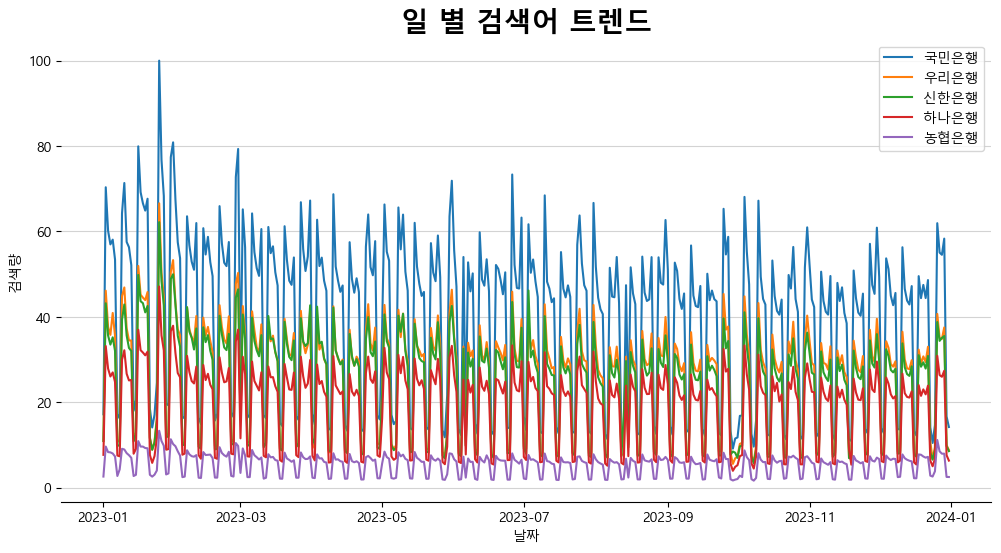

In [56]:
fig = naver.plot_daily_trend()

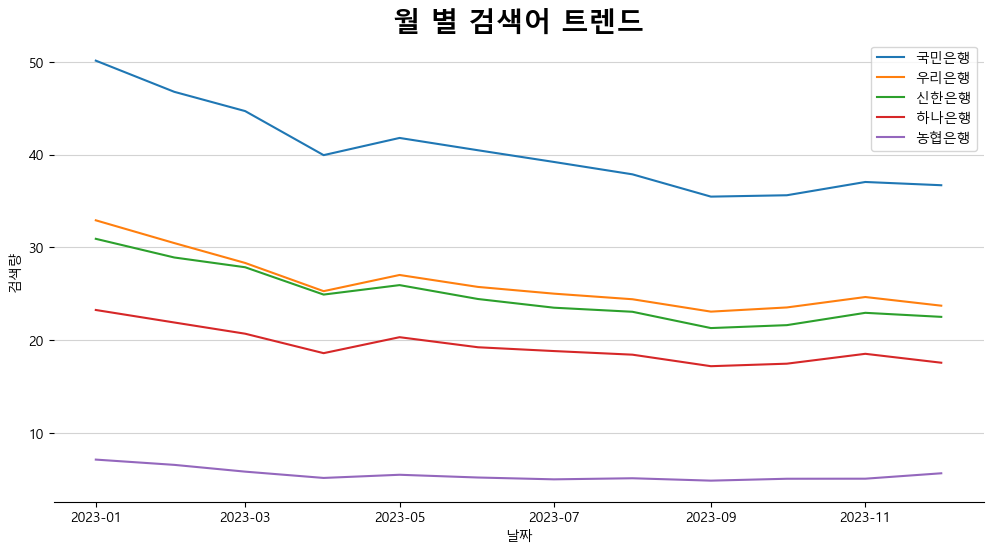

In [57]:
fig_m = naver.plot_monthly_trend()

- 국민은행 > 우리은행 >= 신한은행 > 하나은행 > 농협은행
- 국민은행과 농협은행은 중위그룹과 큰 차이를 보임

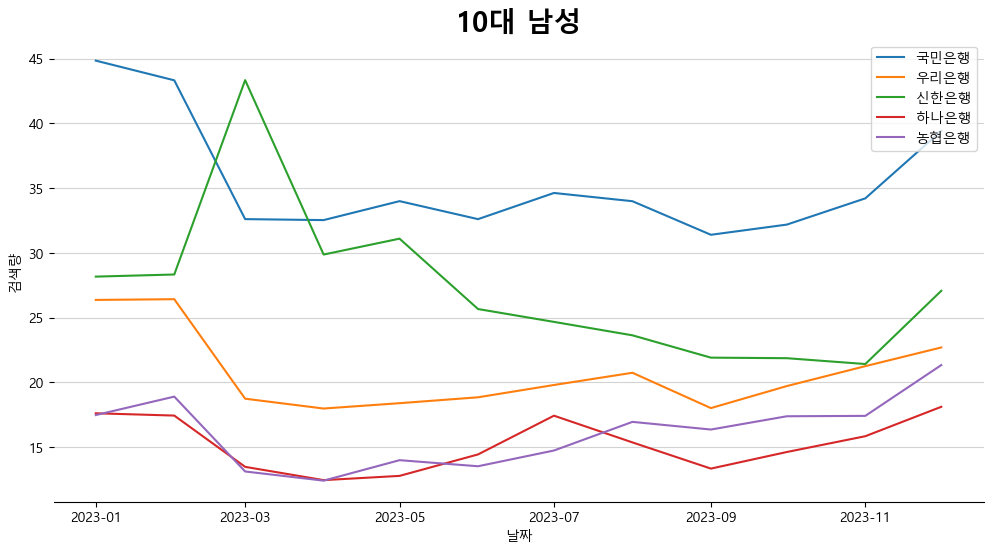

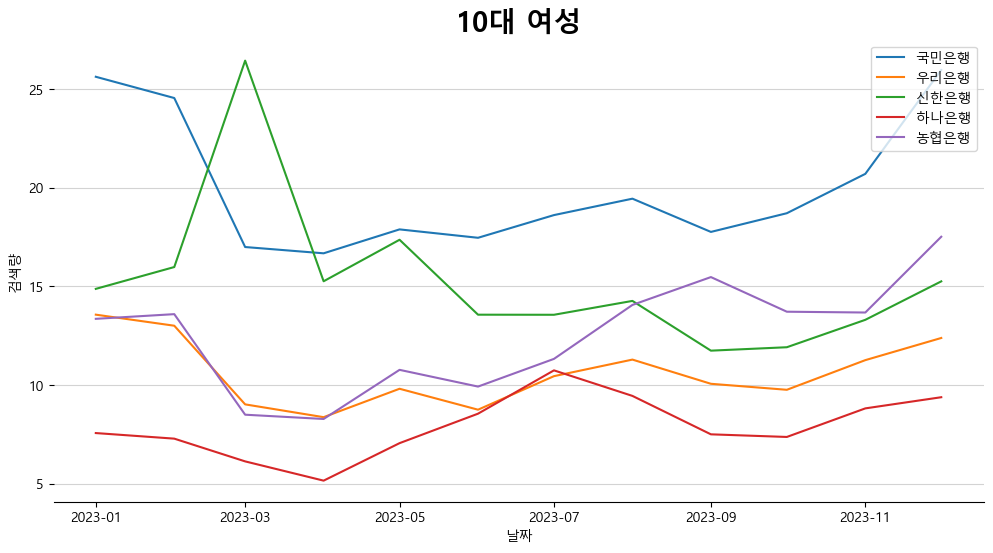

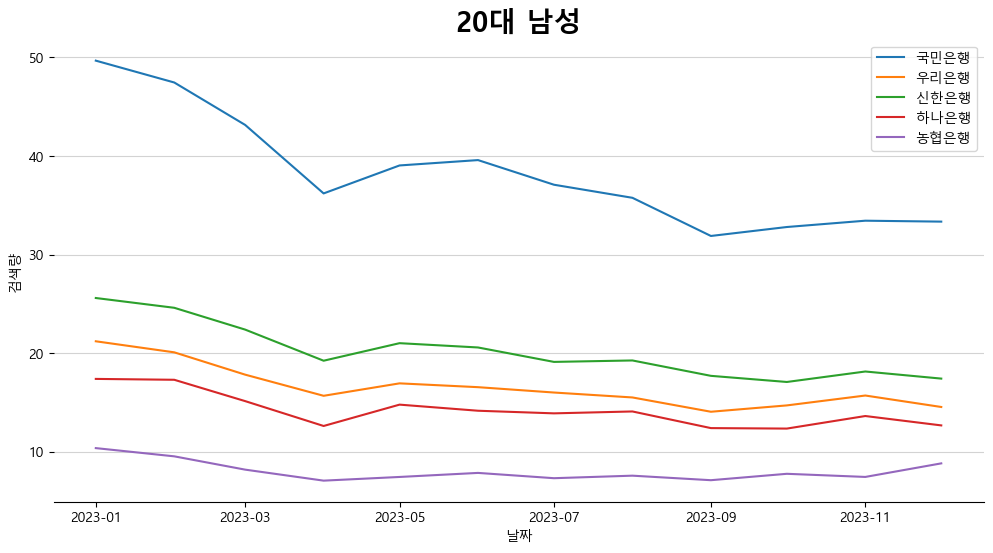

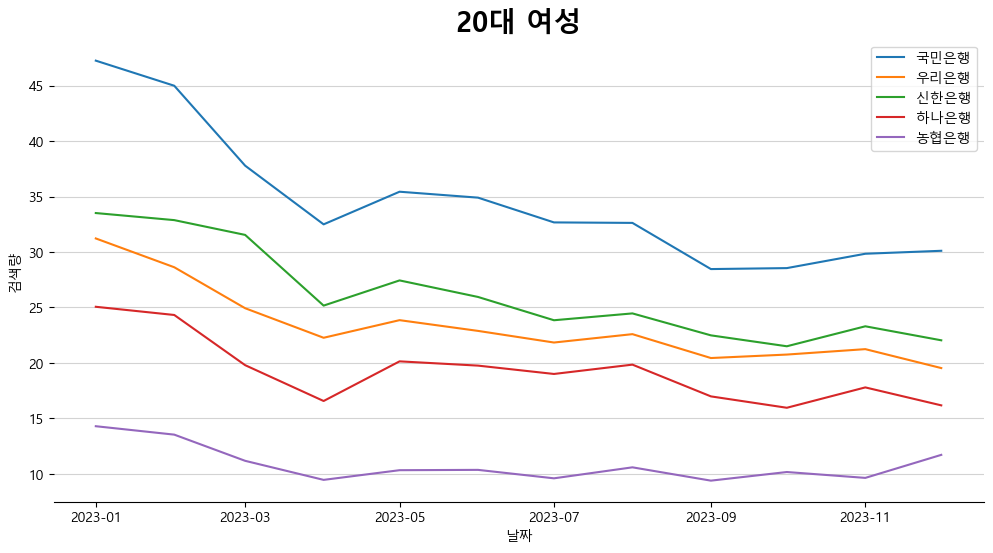

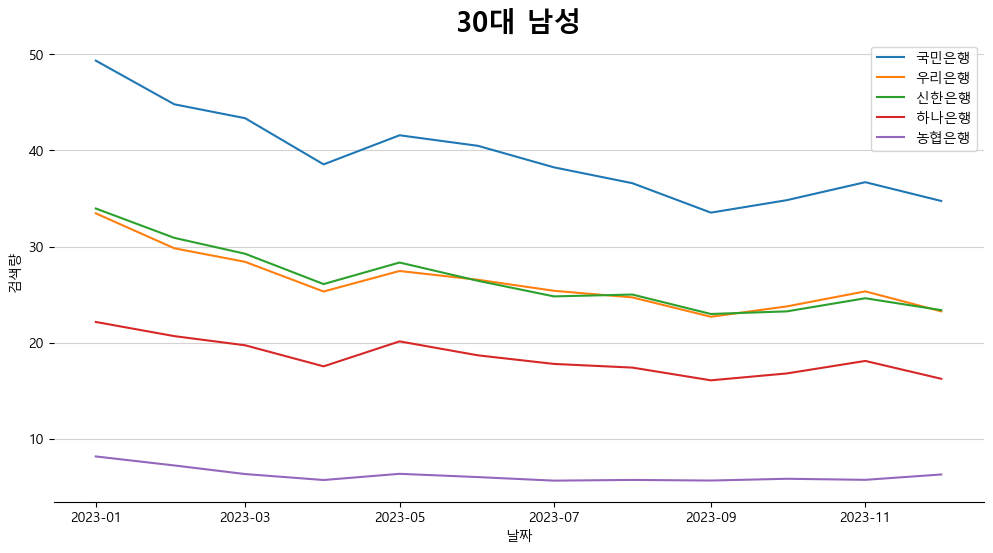

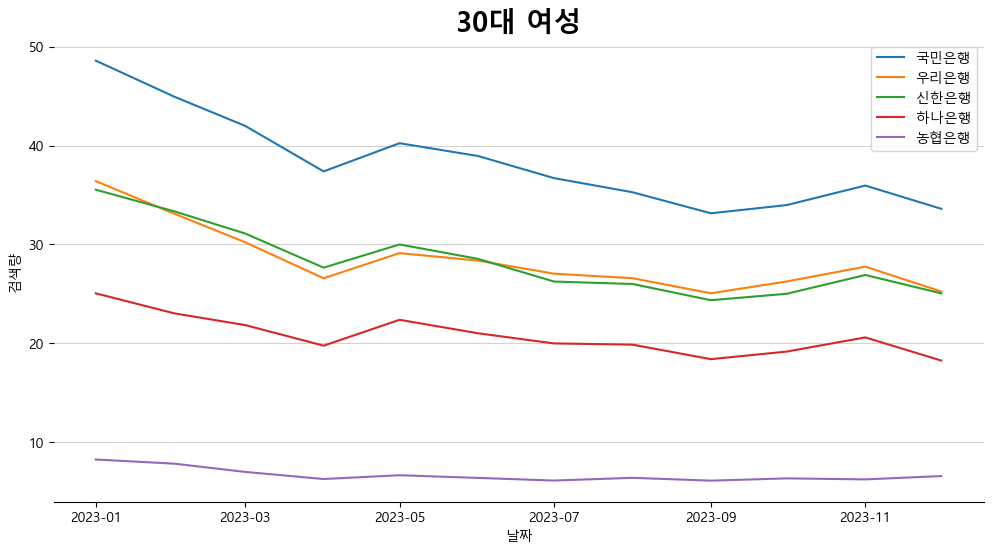

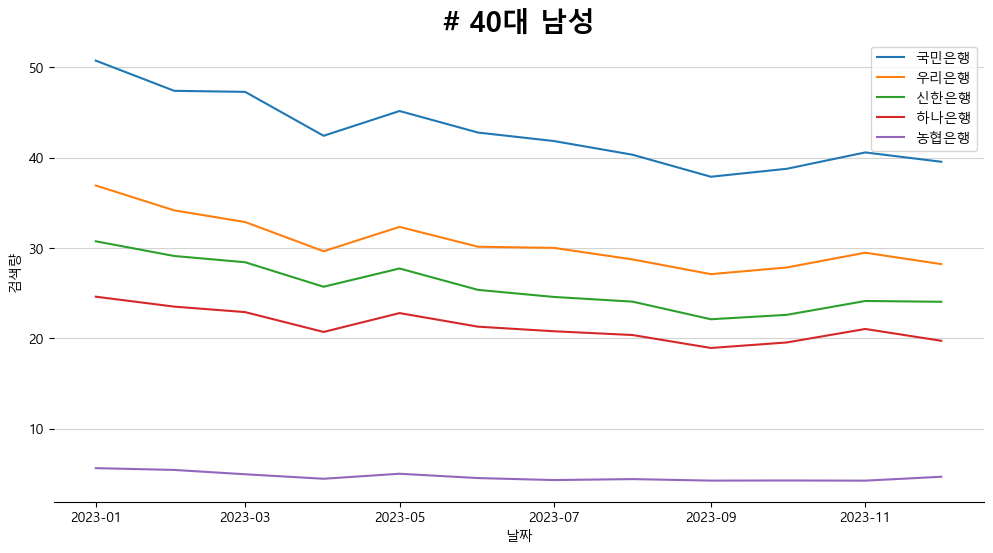

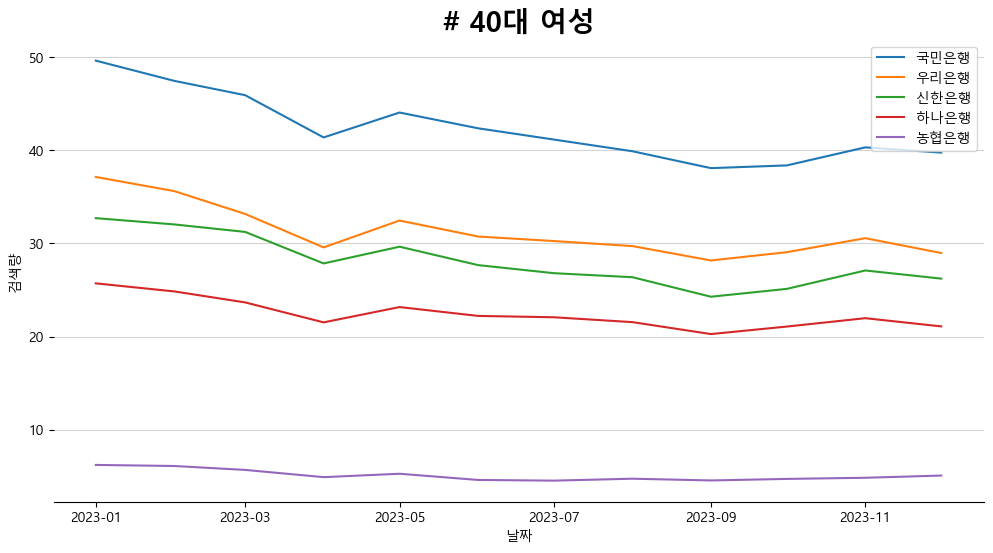

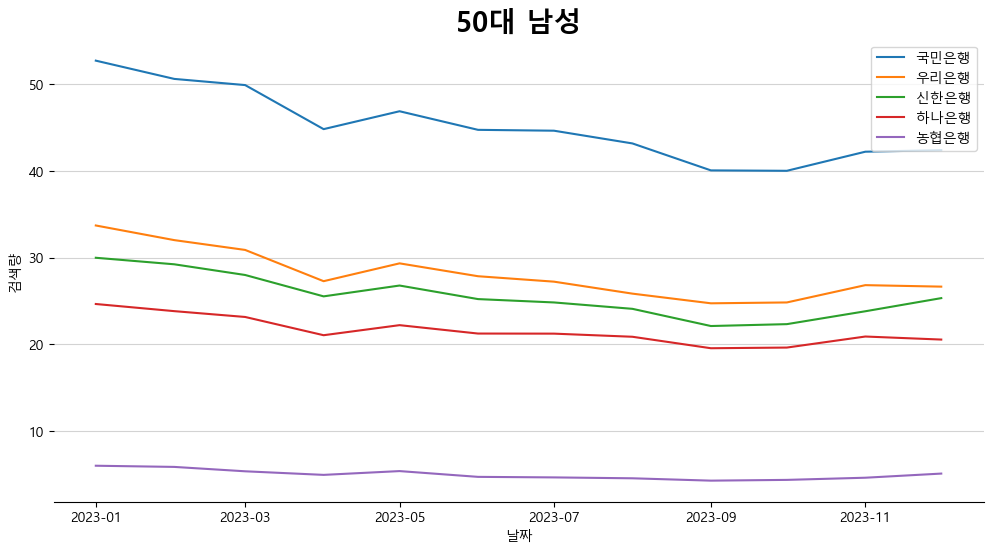

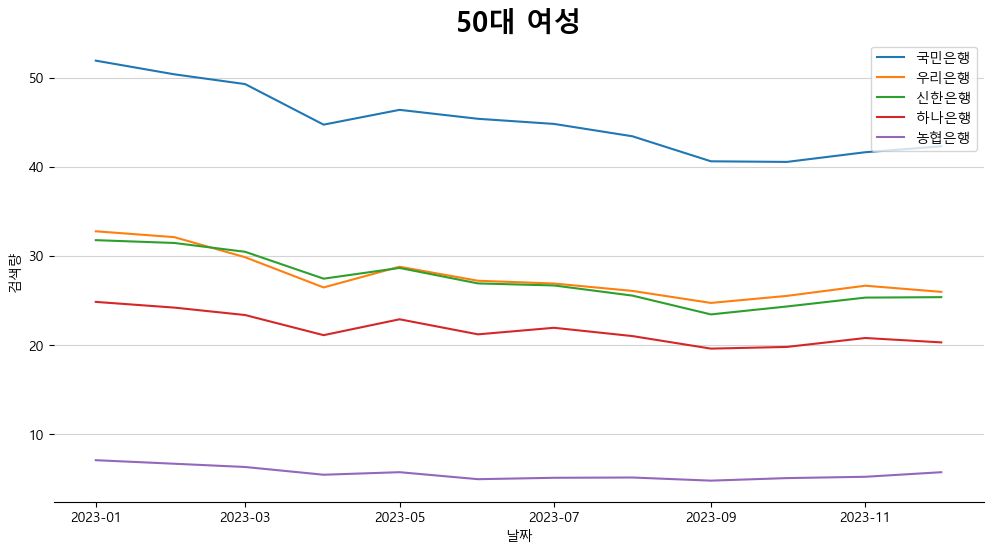

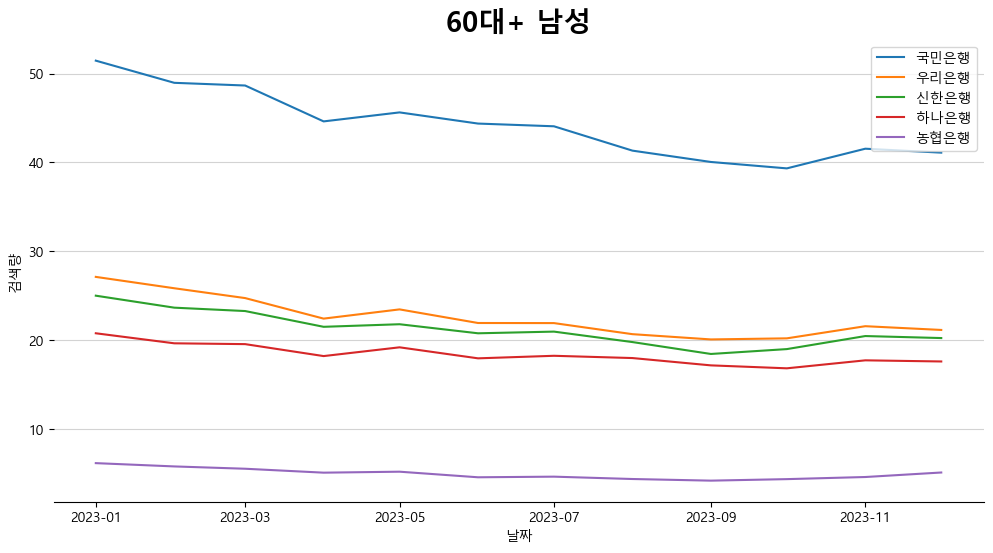

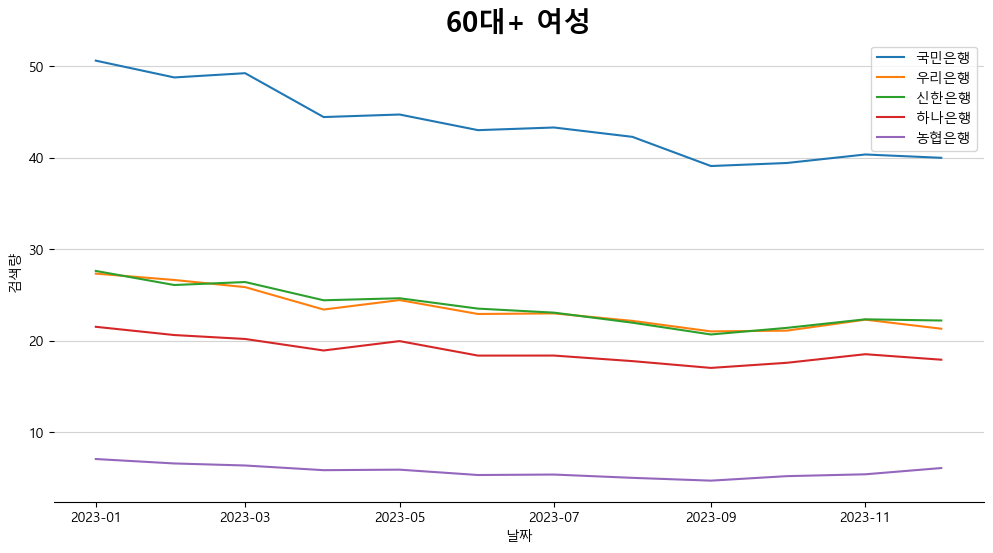

In [58]:
age_gender_combination = [
    (['1', '2'], 'm', '10대 남성'),  # 10대 남성
    (['1', '2'], 'f', '10대 여성'),  # 10대 여성
    (['3', '4'], 'm', '20대 남성'),  # 20대 남성
    (['3', '4'], 'f', '20대 여성'),  # 20대 여성
    (['5', '6'], 'm', '30대 남성'),  # 30대 남성
    (['5', '6'], 'f', '30대 여성'),  # 30대 여성
    (['7', '8'], 'm', '# 40대 남성'),  # 40대 남성
    (['7', '8'], 'f', '# 40대 여성'),  # 40대 여성
    (['9', '10'], 'm', '50대 남성'), # 50대 남성
    (['9', '10'], 'f', '50대 여성'), # 50대 여성
    (['11'], 'm', '60대+ 남성'),  # 60대+ 남성
    (['11'], 'f', '60대+ 여성'),  # 60대+ 여성
]

for age, gender, title in age_gender_combination:
    df = naver.get_data(start, end, 'date', device, age, gender)
    fig = naver.plot_monthly_trend(title)

- 10, 20대는 신한은행 > 우리은행
- 농협은 10대가 가장 검색량이 많았음
- 신한과 우리는 대체로 비슷한 검색량을 보이지만 40대 이상에서 우리 > 신한
- 성별에 따른 차이는 거의 없어 보임
- 10대는 다른 연령대와는 가장 다른 추이를 보임
- 하나은행은 최근 자산이나 실적 대비 검색량이 적음 
    - 점포수가 타은행 대비 적기 때문인지?
    - 브랜드 인지도, 광고의 영향?
- 은행들이 점포를 갈 수록 줄이고 있고, 코로나19 이후 더욱 비대면 서비스의 선호도가 높아졌기 때문에 온라인 검색량이 고객의 은행 선택에 영향을 미칠 수 있음

-> 실제 고객 데이터로 확인할 순 없지만, 검색량으로 추정할 수 있는 관심은행은 연령대에 따라 차이가 있다고 볼 수 있음
- 10대는 검색추이에서 가장 독특한 모습을 보였음. 주거래 은행이나 주요 관심은행이 정해지지 않았다고 볼 수 있음
- 지난 코호트 분석과 연결하면 생애 초기 단계에서 고객과 관계를 맺는게 중요해 보임